In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import validate_data, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
import logging
logging.getLogger("pgmpy").setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.calibration import LabelEncoder
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

c:\Users\romai\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Question 1 : implémentation d'un classifieur Bayésien 

class BayesianClassifier(ClassifierMixin, BaseEstimator):

    def __init__(self, model=None):
        self.model = model

    def fit(self, X, y):
        # Check that X and y have correct shape, set n_features_in_, etc.
        X, y = validate_data(self, X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.feature_names_ = [f"feature_{i}" for i in range(X.shape[1])]


        # If bayesian network model not provided at init, perform structure learning
        if self.model is None:
            # Combine X and y into a single DataFrame for pgmpy
            data_dict = {name: X[:, i] for i, name in enumerate(self.feature_names_)}
            data_dict['target'] = y
            data_df = pd.DataFrame(data_dict)
   
            # Learn the structure using Hill Climb Search
            est = HillClimbSearch(data=data_df)
            estimated_model = est.estimate(scoring_method="bic-d", max_indegree=4, max_iter=int(1e4))
            
            # Create Bayesian Network model
            self.model = DiscreteBayesianNetwork(estimated_model.edges())

        # Estimate parameters from data

        # Fit the model parameters using Bayesian Estimator
        self.model.fit(data_df, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
        self.inference = VariableElimination(self.model)

        # Return the classifier
        return self

    def predict_proba(self, X):
        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = validate_data(self, X, reset=False)

        # Implement prediction here, return classes with probabilities
        predictions_proba = []
        for row in X:
            evidence = {self.feature_names_[i]: row[i] for i in range(X.shape[1])
                        if self.feature_names_[i] in self.model.nodes()}
            query_result = self.inference.query(variables=['target'], evidence=evidence)
            predictions_proba.append(query_result.values)
        return np.array(predictions_proba)

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = validate_data(self, X, reset=False)
       
        # Perform prediction here with predict_proba
        proba = self.predict_proba(X)

        # Return just result (without the probability)
        return self.classes_[np.argmax(proba, axis=1)]

In [3]:
# Question 2 : application du classifieur Bayésien au dataset 

# Charger le dataset
df = pd.read_csv('insurance_claims.csv')
df = df.rename(columns={'fraud_reported': 'target'})

# Définir la cible
X = df.drop(columns=['target'])
y = df['target']

X = X.dropna(axis=1, how='all')
# Séparation num/cat
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Pré-traitement
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('discretizer', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

# Pipeline complet
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BayesianClassifier())
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement
clf_pipeline.fit(X_train, y_train)

# Prédiction
y_pred = clf_pipeline.predict(X_test)

# Évaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

  0%|          | 12/10000 [00:04<1:04:11,  2.59it/s]


Accuracy: 0.78
              precision    recall  f1-score   support

           N       0.86      0.83      0.85       145
           Y       0.59      0.65      0.62        55

    accuracy                           0.78       200
   macro avg       0.73      0.74      0.73       200
weighted avg       0.79      0.78      0.78       200



In [5]:
# Question 3 : benchmark against other one other scikit learn classifiers

# Définir les modèles
models = {
    "Bayesian": BayesianClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=10000, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Stocker les scores
accuracies = []
classif_models = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    print(f"=== {name} ===")
    print("Cross-validated Accuracy: %.3f ± %.3f" % (scores.mean(), scores.std()))
    accuracies.append(scores)
    classif_models.append(name)

  0%|          | 13/10000 [00:04<1:00:48,  2.74it/s]


=== Bayesian ===
Cross-validated Accuracy: 0.814 ± 0.017
=== RandomForest ===
Cross-validated Accuracy: 0.792 ± 0.011
=== LogisticRegression ===
Cross-validated Accuracy: 0.775 ± 0.019


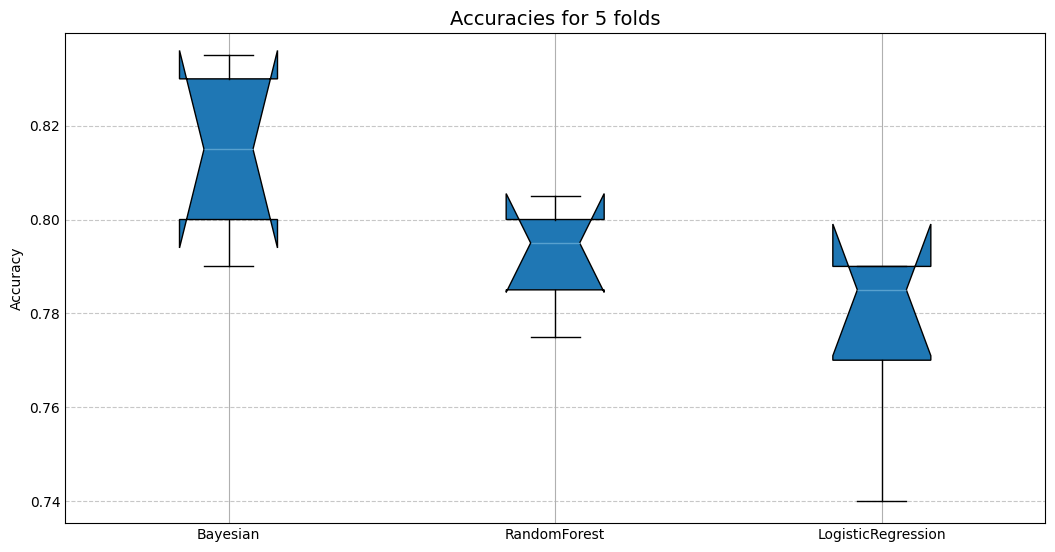

In [12]:
# Afficher le boxplot
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(figsize=(10, 5))
axs.boxplot(accuracies, notch=True, tick_labels=classif_models, patch_artist=True)
axs.set_title('Accuracies for 5 folds', fontsize=14)
axs.set_ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Question 4 : amongst the wrongfully classified claims, select 5 instances and use the structure of the learned bayesian network, to interpret the misclassification. 

# Prédictions
y_pred = clf_pipeline.predict(X_test)

# Sélection des erreurs
misclassified_mask = y_pred != y_test
X_misclassified = X_test[misclassified_mask]
y_true_misclassified = y_test[misclassified_mask]
y_pred_misclassified = pd.Series(y_pred[misclassified_mask], index=X_misclassified.index)

# Prendre les 5 premières erreurs
X_selected = X_misclassified.head(5)
y_true_selected = y_true_misclassified.loc[X_selected.index]
y_pred_selected = y_pred_misclassified.loc[X_selected.index]

In [6]:
# Accès au modèle appris
bayes_model = clf_pipeline.named_steps['classifier'].model
inference = VariableElimination(bayes_model)

for i in X_selected.index:
    instance = X_selected.loc[i]
    evidence = {f"feature_{j}": instance[j] for j in range(len(instance))}
    
    # Distribution postérieure
    posterior = inference.query(variables=['target'], evidence=evidence)
    
    print(f"\n--- Instance {i} ---")
    print(f"True label: {y_true_selected.loc[i]}")
    print(f"Predicted label: {y_pred_selected.loc[i]}")
    print("Posterior distribution over target:")
    print(posterior)

    # Optionnel : explorer les dépendances
    print("\nVariables influentes (parents de 'target'):")
    print([parent for parent in bayes_model.get_parents('target')])


C:\Users\romai\AppData\Local\Temp\ipykernel_4408\2317294940.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  evidence = {f"feature_{j}": instance[j] for j in range(len(instance))}
c:\Users\romai\AppData\Local\Programs\Python\Python313\Lib\site-packages\pgmpy\inference\ExactInference.py:784: SyntaxWarning: invalid escape sequence '\s'
  .. math:: \sum_{C_i - S_{i, j}} \beta_i = \sum_{C_j - S_{i, j}} \beta_j = \mu_{i, j}


ValueError: Node feature_2 not in graph